In [ ]:
# Installed required packages
!pip install yfinance optuna transformers

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import yfinance as yf
import requests
from bs4 import BeautifulSoup
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import datetime
import time
from datetime import datetime, timedelta
import optuna
import os
import warnings
import logging

# To suppress warnings
warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(level=logging.WARNING)

# Set up sentiment analysis pipeline with specified model and tokenizer
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_analyzer = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

# Function to scrape Bloomberg News and perform sentiment analysis
def scrape_bloomberg_news():
    url = 'https://www.bloomberg.com'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    articles = []
    for item in soup.find_all('article'):
        headline = item.find('h3')
        if headline:
            headline_text = headline.get_text(strip=True)
            link = headline.find('a')['href']
            if link.startswith('/'):
                link = url + link
            articles.append((headline_text, link))

    return articles

# Function to perform sentiment analysis on headlines
def analyze_sentiments(headlines):
    sentiments = []
    for headline in headlines:
        sentiment = sentiment_analyzer(headline)
        sentiments.append(sentiment[0]['score'] if sentiment[0]['label'] == 'POSITIVE' else -sentiment[0]['score'])
    return np.mean(sentiments)  # Return the average sentiment score

# Function to download financial data from yfinance
def download_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data['Return'] = data['Adj Close'].pct_change().fillna(0)
    data['Date'] = data.index
    return data

# Function to calculate sentiments for all dates in the data
def calculate_sentiments(data, news_articles):
    sentiments = []
    for date in data.index:
        relevant_headlines = [headline for headline, link in news_articles if date.strftime('%Y-%m-%d') in link]
        if relevant_headlines:
            sentiment = analyze_sentiments(relevant_headlines)
        else:
            sentiment = 0  # Neutral sentiment if no news
        sentiments.append(sentiment)
    return sentiments

# Function to create features and labels
def create_features_labels(data, seq_length=50):
    X, y = [], []
    for i in range(len(data) - seq_length):
        features = np.column_stack((data['Return'].values[i:i+seq_length],
                                    data['Sentiment'].values[i:i+seq_length]))
        X.append(features)
        y.append(1 if data['Return'].values[i+seq_length] > 0 else 0)
    X, y = np.array(X), np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 2)  # Add feature dimension
    print(f"create_features_labels output - X shape: {X.shape}, y shape: {np.array(y).shape}")
    return X, y

# Define the 1D Convolutional Neural Network
class Conv1DNN(nn.Module):
    def __init__(self, n_filters1, n_filters2, kernel_size1, kernel_size2, fc_units, seq_length=50):
        super(Conv1DNN, self).__init__()
        self.conv1 = nn.Conv1d(2, n_filters1, kernel_size=kernel_size1, padding=kernel_size1//2)
        self.conv2 = nn.Conv1d(n_filters1, n_filters2, kernel_size=kernel_size2, padding=kernel_size2//2)
        self.pool = nn.MaxPool1d(2)

        # Placeholder for fc1, will be initialized in forward pass
        self.fc1 = None
        self.fc2 = nn.Linear(fc_units, 1)
        self.fc_units = fc_units
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape to (batch, channels, seq_length)
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten

        # Initialize fc1 if it's the first forward pass
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.shape[1], self.fc_units)
            print(f"Initialized fc1 with input size: {x.shape[1]}")

        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Training function
def train(model, dataloader, criterion, optimizer, epochs, verbose=False):
    model.train()
    for epoch in range(epochs):
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            if verbose:
                print(f"Outputs before sigmoid: {outputs}")
            loss = criterion(outputs.squeeze(), labels.squeeze())
            if verbose:
                print(f"Loss: {loss.item()}")
            loss.backward()
            optimizer.step()

# Evaluation function
def evaluate_model(model, X, y):
    model.eval()
    with torch.no_grad():
        y_pred = model(X).numpy().flatten()
        y_true = y.numpy().flatten()
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
    return roc_auc

# Optuna objective function
def objective(trial, X, y):
    n_filters1 = trial.suggest_int('n_filters1', 16, 64)
    n_filters2 = trial.suggest_int('n_filters2', 16, 64)
    kernel_size1 = trial.suggest_int('kernel_size1', 3, 7)
    kernel_size2 = trial.suggest_int('kernel_size2', 3, 7)
    fc_units = trial.suggest_int('fc_units', 32, 128)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2)
    epochs = trial.suggest_int('epochs', 10, 50)

    model = Conv1DNN(n_filters1, n_filters2, kernel_size1, kernel_size2, fc_units)
    print(f"Model structure before first forward pass: {model}")

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Perform a single forward pass to initialize fc1
    for inputs, _ in dataloader:
        _ = model(inputs)
        break

    print(f"Model structure after first forward pass: {model}")

    # Reinitialize the optimizer with the new parameters
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train(model, dataloader, criterion, optimizer, epochs)
    roc_auc = evaluate_model(model, X, y)
    return roc_auc

# Train the best model
def train_best_model(best_params, X, y):
    model = Conv1DNN(
        n_filters1=best_params['n_filters1'],
        n_filters2=best_params['n_filters2'],
        kernel_size1=best_params['kernel_size1'],
        kernel_size2=best_params['kernel_size2'],
        fc_units=best_params['fc_units']
    )
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    train(model, dataloader, criterion, optimizer, epochs=best_params['epochs'])
    roc_auc = evaluate_model(model, X, y)
    return model, roc_auc

# Function to get the latest data and make predictions
def get_latest_data_and_predict(model, data, seq_length=50):
    X, _ = create_features_labels(data[-seq_length:])
    X = torch.tensor(X, dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        y_pred = model(X).numpy().flatten()

    return y_pred[-1]  # Return the latest prediction

# Backtest function
def backtest_strategy(model, data, threshold=0.5):
    initial_balance = 10000  # Starting with $10,000
    balance = initial_balance
    holdings = 0
    trade_log = []

    for i in range(len(data) - 50):
        X, _ = create_features_labels(data[i:i+51])
        X = torch.tensor(X, dtype=torch.float32)

        model.eval()
        with torch.no_grad():
            prediction = model(X).numpy().flatten()[-1]

        price = data['Adj Close'].iloc[i+50]
        if prediction > threshold:
            if holdings == 0:  # Buy
                holdings = balance / price
                balance = 0
                trade_log.append((data.index[i+50], 'BUY', price))
        else:
            if holdings > 0:  # Sell
                balance = holdings * price
                holdings = 0
                trade_log.append((data.index[i+50], 'SELL', price))

    final_balance = balance + (holdings * data['Adj Close'].iloc[-1])
    return final_balance, trade_log

# Main function
def main():
    # Train models
    ticker = 'AAPL'
    start_date = '2018-01-01'
    end_date = '2023-01-01'
    data = download_data(ticker, start_date, end_date)

    news_articles = scrape_bloomberg_news()
    data['Sentiment'] = calculate_sentiments(data, news_articles)

    data['Sentiment'].fillna(data['Sentiment'].mean(), inplace=True)

    X, y = create_features_labels(data)
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    # Debug statements for X and y
    print(f"X shape: {X.shape}, y shape: {y.shape}")
    print(f"y unique values: {torch.unique(y)}")

    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X, y), n_trials=50)
    best_params = study.best_params

    model, roc_auc = train_best_model(best_params, X, y)
    print('ROC AUC of the best model:', roc_auc)

    # Backtest the strategy
    final_balance, trade_log = backtest_strategy(model, data)
    print(f'Final balance after backtesting: ${final_balance:.2f}')
    for trade in trade_log:
        print(trade)

if __name__ == "__main__":
    main()

[*********************100%%**********************]  1 of 1 completed
[I 2024-06-25 21:53:21,744] A new study created in memory with name: no-name-fc2616fe-c813-4256-b1ce-47d51f143b6b


create_features_labels output - X shape: (1209, 50, 2), y shape: (1209,)
X shape: torch.Size([1209, 50, 2]), y shape: torch.Size([1209, 1])
y unique values: tensor([0., 1.])
Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 46, kernel_size=(4,), stride=(1,), padding=(2,))
  (conv2): Conv1d(46, 28, kernel_size=(6,), stride=(1,), padding=(3,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=43, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 364
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 46, kernel_size=(4,), stride=(1,), padding=(2,))
  (conv2): Conv1d(46, 28, kernel_size=(6,), stride=(1,), padding=(3,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=43, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=364, out_features=43, bias=True)
)


[I 2024-06-25 21:53:32,444] Trial 0 finished with value: 0.4978319969244288 and parameters: {'n_filters1': 46, 'n_filters2': 28, 'kernel_size1': 4, 'kernel_size2': 6, 'fc_units': 43, 'learning_rate': 0.00014418452001617753, 'epochs': 29}. Best is trial 0 with value: 0.4978319969244288.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 19, kernel_size=(4,), stride=(1,), padding=(2,))
  (conv2): Conv1d(19, 28, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=95, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 336
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 19, kernel_size=(4,), stride=(1,), padding=(2,))
  (conv2): Conv1d(19, 28, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=95, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=336, out_features=95, bias=True)
)


[I 2024-06-25 21:53:43,504] Trial 1 finished with value: 0.5199225615114235 and parameters: {'n_filters1': 19, 'n_filters2': 28, 'kernel_size1': 4, 'kernel_size2': 5, 'fc_units': 95, 'learning_rate': 0.004041247446088214, 'epochs': 45}. Best is trial 1 with value: 0.5199225615114235.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 26, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(26, 38, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=44, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 494
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 26, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(26, 38, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=44, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=494, out_features=44, bias=True)
)


[I 2024-06-25 21:53:54,810] Trial 2 finished with value: 0.6358441344463973 and parameters: {'n_filters1': 26, 'n_filters2': 38, 'kernel_size1': 5, 'kernel_size2': 4, 'fc_units': 44, 'learning_rate': 0.0018184524198121906, 'epochs': 44}. Best is trial 2 with value: 0.6358441344463973.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 38, kernel_size=(6,), stride=(1,), padding=(3,))
  (conv2): Conv1d(38, 33, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=70, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 396
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 38, kernel_size=(6,), stride=(1,), padding=(3,))
  (conv2): Conv1d(38, 33, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=70, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=396, out_features=70, bias=True)
)


[I 2024-06-25 21:53:59,571] Trial 3 finished with value: 0.5 and parameters: {'n_filters1': 38, 'n_filters2': 33, 'kernel_size1': 6, 'kernel_size2': 3, 'fc_units': 70, 'learning_rate': 0.005661726867700456, 'epochs': 12}. Best is trial 2 with value: 0.6358441344463973.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 20, kernel_size=(4,), stride=(1,), padding=(2,))
  (conv2): Conv1d(20, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=85, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 192
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 20, kernel_size=(4,), stride=(1,), padding=(2,))
  (conv2): Conv1d(20, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=85, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=192, out_features=85, bias=True)
)


[I 2024-06-25 21:54:02,741] Trial 4 finished with value: 0.5 and parameters: {'n_filters1': 20, 'n_filters2': 16, 'kernel_size1': 4, 'kernel_size2': 7, 'fc_units': 85, 'learning_rate': 0.004247722529683734, 'epochs': 12}. Best is trial 2 with value: 0.6358441344463973.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 64, kernel_size=(6,), stride=(1,), padding=(3,))
  (conv2): Conv1d(64, 22, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=38, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 264
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 64, kernel_size=(6,), stride=(1,), padding=(3,))
  (conv2): Conv1d(64, 22, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=38, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=264, out_features=38, bias=True)
)


[I 2024-06-25 21:54:11,039] Trial 5 finished with value: 0.5 and parameters: {'n_filters1': 64, 'n_filters2': 22, 'kernel_size1': 6, 'kernel_size2': 5, 'fc_units': 38, 'learning_rate': 0.007395728810202265, 'epochs': 18}. Best is trial 2 with value: 0.6358441344463973.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(64, 27, kernel_size=(7,), stride=(1,), padding=(3,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=40, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 324
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(64, 27, kernel_size=(7,), stride=(1,), padding=(3,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=40, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=324, out_features=40, bias=True)
)


[I 2024-06-25 21:54:20,725] Trial 6 finished with value: 0.5094560083479789 and parameters: {'n_filters1': 64, 'n_filters2': 27, 'kernel_size1': 5, 'kernel_size2': 7, 'fc_units': 40, 'learning_rate': 0.0013874397070272626, 'epochs': 17}. Best is trial 2 with value: 0.6358441344463973.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 62, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(62, 22, kernel_size=(7,), stride=(1,), padding=(3,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 264
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 62, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(62, 22, kernel_size=(7,), stride=(1,), padding=(3,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=264, out_features=32, bias=True)
)


[I 2024-06-25 21:54:32,706] Trial 7 finished with value: 0.5507180909490333 and parameters: {'n_filters1': 62, 'n_filters2': 22, 'kernel_size1': 7, 'kernel_size2': 7, 'fc_units': 32, 'learning_rate': 0.0005091024713152606, 'epochs': 31}. Best is trial 2 with value: 0.6358441344463973.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 42, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(42, 48, kernel_size=(7,), stride=(1,), padding=(3,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=60, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 576
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 42, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(42, 48, kernel_size=(7,), stride=(1,), padding=(3,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=60, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=576, out_features=60, bias=True)
)


[I 2024-06-25 21:54:43,404] Trial 8 finished with value: 0.5 and parameters: {'n_filters1': 42, 'n_filters2': 48, 'kernel_size1': 5, 'kernel_size2': 7, 'fc_units': 60, 'learning_rate': 0.008374445491028282, 'epochs': 24}. Best is trial 2 with value: 0.6358441344463973.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 59, kernel_size=(4,), stride=(1,), padding=(2,))
  (conv2): Conv1d(59, 16, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=111, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 208
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 59, kernel_size=(4,), stride=(1,), padding=(2,))
  (conv2): Conv1d(59, 16, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=111, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=208, out_features=111, bias=True)
)


[I 2024-06-25 21:54:54,154] Trial 9 finished with value: 0.5 and parameters: {'n_filters1': 59, 'n_filters2': 16, 'kernel_size1': 4, 'kernel_size2': 4, 'fc_units': 111, 'learning_rate': 0.00840348051927628, 'epochs': 32}. Best is trial 2 with value: 0.6358441344463973.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 28, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(28, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 768
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 28, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(28, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=768, out_features=128, bias=True)
)


[I 2024-06-25 21:55:13,528] Trial 10 finished with value: 0.6868368299648506 and parameters: {'n_filters1': 28, 'n_filters2': 64, 'kernel_size1': 3, 'kernel_size2': 3, 'fc_units': 128, 'learning_rate': 0.002440591949393363, 'epochs': 48}. Best is trial 10 with value: 0.6868368299648506.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 29, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(29, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=116, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 768
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 29, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(29, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=116, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=768, out_features=116, bias=True)
)


[I 2024-06-25 21:55:31,028] Trial 11 finished with value: 0.5015625 and parameters: {'n_filters1': 29, 'n_filters2': 64, 'kernel_size1': 3, 'kernel_size2': 3, 'fc_units': 116, 'learning_rate': 0.0025416095488266246, 'epochs': 50}. Best is trial 10 with value: 0.6868368299648506.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 30, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(30, 46, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=125, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 598
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 30, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(30, 46, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=125, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=598, out_features=125, bias=True)
)


[I 2024-06-25 21:55:44,153] Trial 12 finished with value: 0.5258457820738137 and parameters: {'n_filters1': 30, 'n_filters2': 46, 'kernel_size1': 3, 'kernel_size2': 4, 'fc_units': 125, 'learning_rate': 0.002515020358302003, 'epochs': 41}. Best is trial 10 with value: 0.6868368299648506.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 29, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(29, 64, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=60, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 832
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 29, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(29, 64, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=60, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=832, out_features=60, bias=True)
)


[I 2024-06-25 21:55:56,760] Trial 13 finished with value: 0.6691344463971882 and parameters: {'n_filters1': 29, 'n_filters2': 64, 'kernel_size1': 7, 'kernel_size2': 4, 'fc_units': 60, 'learning_rate': 0.0026809200207125634, 'epochs': 39}. Best is trial 10 with value: 0.6868368299648506.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 36, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(36, 63, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=62, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 756
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 36, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(36, 63, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=62, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=756, out_features=62, bias=True)
)


[I 2024-06-25 21:56:09,403] Trial 14 finished with value: 0.5 and parameters: {'n_filters1': 36, 'n_filters2': 63, 'kernel_size1': 7, 'kernel_size2': 3, 'fc_units': 62, 'learning_rate': 0.005719944338734113, 'epochs': 38}. Best is trial 10 with value: 0.6868368299648506.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 51, kernel_size=(6,), stride=(1,), padding=(3,))
  (conv2): Conv1d(51, 56, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=91, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 728
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 51, kernel_size=(6,), stride=(1,), padding=(3,))
  (conv2): Conv1d(51, 56, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=91, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=728, out_features=91, bias=True)
)


[I 2024-06-25 21:56:29,421] Trial 15 finished with value: 0.5 and parameters: {'n_filters1': 51, 'n_filters2': 56, 'kernel_size1': 6, 'kernel_size2': 4, 'fc_units': 91, 'learning_rate': 0.003667163026807852, 'epochs': 49}. Best is trial 10 with value: 0.6868368299648506.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 24, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(24, 56, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=101, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 672
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 24, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(24, 56, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=101, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=672, out_features=101, bias=True)
)


[I 2024-06-25 21:56:41,040] Trial 16 finished with value: 0.5010819420035149 and parameters: {'n_filters1': 24, 'n_filters2': 56, 'kernel_size1': 7, 'kernel_size2': 3, 'fc_units': 101, 'learning_rate': 0.0032315708292076245, 'epochs': 37}. Best is trial 10 with value: 0.6868368299648506.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 33, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(33, 56, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=78, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 728
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 33, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(33, 56, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=78, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=728, out_features=78, bias=True)
)


[I 2024-06-25 21:56:53,440] Trial 17 finished with value: 0.5 and parameters: {'n_filters1': 33, 'n_filters2': 56, 'kernel_size1': 3, 'kernel_size2': 4, 'fc_units': 78, 'learning_rate': 0.009988574231059593, 'epochs': 35}. Best is trial 10 with value: 0.6868368299648506.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 23, kernel_size=(6,), stride=(1,), padding=(3,))
  (conv2): Conv1d(23, 49, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=52, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 588
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 23, kernel_size=(6,), stride=(1,), padding=(3,))
  (conv2): Conv1d(23, 49, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=52, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=588, out_features=52, bias=True)
)


[I 2024-06-25 21:57:05,731] Trial 18 finished with value: 0.6390844683655537 and parameters: {'n_filters1': 23, 'n_filters2': 49, 'kernel_size1': 6, 'kernel_size2': 5, 'fc_units': 52, 'learning_rate': 0.0050376801253772035, 'epochs': 45}. Best is trial 10 with value: 0.6868368299648506.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(16, 59, kernel_size=(6,), stride=(1,), padding=(3,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 767
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(16, 59, kernel_size=(6,), stride=(1,), padding=(3,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=767, out_features=128, bias=True)
)


[I 2024-06-25 21:57:19,336] Trial 19 finished with value: 0.5562527460456942 and parameters: {'n_filters1': 16, 'n_filters2': 59, 'kernel_size1': 7, 'kernel_size2': 6, 'fc_units': 128, 'learning_rate': 0.0014164540173881165, 'epochs': 40}. Best is trial 10 with value: 0.6868368299648506.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 51, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=68, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 612
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 51, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=68, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=612, out_features=68, bias=True)
)


[I 2024-06-25 21:57:28,568] Trial 20 finished with value: 0.5244288224956064 and parameters: {'n_filters1': 32, 'n_filters2': 51, 'kernel_size1': 3, 'kernel_size2': 3, 'fc_units': 68, 'learning_rate': 0.003045907579153485, 'epochs': 27}. Best is trial 10 with value: 0.6868368299648506.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 25, kernel_size=(6,), stride=(1,), padding=(3,))
  (conv2): Conv1d(25, 44, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=57, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 528
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 25, kernel_size=(6,), stride=(1,), padding=(3,))
  (conv2): Conv1d(25, 44, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=57, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=528, out_features=57, bias=True)
)


[I 2024-06-25 21:57:42,630] Trial 21 finished with value: 0.6180387741652021 and parameters: {'n_filters1': 25, 'n_filters2': 44, 'kernel_size1': 6, 'kernel_size2': 5, 'fc_units': 57, 'learning_rate': 0.00487751228710734, 'epochs': 45}. Best is trial 10 with value: 0.6868368299648506.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 22, kernel_size=(6,), stride=(1,), padding=(3,))
  (conv2): Conv1d(22, 52, kernel_size=(6,), stride=(1,), padding=(3,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=73, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 676
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 22, kernel_size=(6,), stride=(1,), padding=(3,))
  (conv2): Conv1d(22, 52, kernel_size=(6,), stride=(1,), padding=(3,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=73, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=676, out_features=73, bias=True)
)


[I 2024-06-25 21:57:56,600] Trial 22 finished with value: 0.5029286577328647 and parameters: {'n_filters1': 22, 'n_filters2': 52, 'kernel_size1': 6, 'kernel_size2': 6, 'fc_units': 73, 'learning_rate': 0.006415815106837205, 'epochs': 47}. Best is trial 10 with value: 0.6868368299648506.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 28, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(28, 62, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=52, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 806
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 28, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(28, 62, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=52, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=806, out_features=52, bias=True)
)


[I 2024-06-25 21:58:09,390] Trial 23 finished with value: 0.8900153778558875 and parameters: {'n_filters1': 28, 'n_filters2': 62, 'kernel_size1': 7, 'kernel_size2': 4, 'fc_units': 52, 'learning_rate': 0.005014020644716624, 'epochs': 42}. Best is trial 23 with value: 0.8900153778558875.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 42, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(42, 61, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=53, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 793
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 42, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(42, 61, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=53, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=793, out_features=53, bias=True)
)


[I 2024-06-25 21:58:23,923] Trial 24 finished with value: 0.5 and parameters: {'n_filters1': 42, 'n_filters2': 61, 'kernel_size1': 7, 'kernel_size2': 4, 'fc_units': 53, 'learning_rate': 0.002120356830797581, 'epochs': 42}. Best is trial 23 with value: 0.8900153778558875.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 35, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(35, 58, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=49, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 696
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 35, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(35, 58, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=49, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=696, out_features=49, bias=True)
)


[I 2024-06-25 21:58:34,396] Trial 25 finished with value: 0.5 and parameters: {'n_filters1': 35, 'n_filters2': 58, 'kernel_size1': 5, 'kernel_size2': 3, 'fc_units': 49, 'learning_rate': 0.004378270806216376, 'epochs': 37}. Best is trial 23 with value: 0.8900153778558875.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 28, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(28, 64, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 832
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 28, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(28, 64, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=832, out_features=64, bias=True)
)


[I 2024-06-25 21:58:45,005] Trial 26 finished with value: 0.550260874340949 and parameters: {'n_filters1': 28, 'n_filters2': 64, 'kernel_size1': 7, 'kernel_size2': 4, 'fc_units': 64, 'learning_rate': 0.000955924937098031, 'epochs': 35}. Best is trial 23 with value: 0.8900153778558875.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 17, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(17, 53, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=82, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 636
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 17, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(17, 53, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=82, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=636, out_features=82, bias=True)
)


[I 2024-06-25 21:58:57,878] Trial 27 finished with value: 0.6369398066783831 and parameters: {'n_filters1': 17, 'n_filters2': 53, 'kernel_size1': 7, 'kernel_size2': 3, 'fc_units': 82, 'learning_rate': 0.0031587367344769997, 'epochs': 48}. Best is trial 23 with value: 0.8900153778558875.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 48, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(48, 60, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=75, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 780
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 48, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(48, 60, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=75, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=780, out_features=75, bias=True)
)


[I 2024-06-25 21:59:12,592] Trial 28 finished with value: 0.5 and parameters: {'n_filters1': 48, 'n_filters2': 60, 'kernel_size1': 5, 'kernel_size2': 4, 'fc_units': 75, 'learning_rate': 0.006089187973973064, 'epochs': 41}. Best is trial 23 with value: 0.8900153778558875.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 40, kernel_size=(4,), stride=(1,), padding=(2,))
  (conv2): Conv1d(40, 38, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=47, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 456
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 40, kernel_size=(4,), stride=(1,), padding=(2,))
  (conv2): Conv1d(40, 38, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=47, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=456, out_features=47, bias=True)
)


[I 2024-06-25 21:59:21,592] Trial 29 finished with value: 0.5585237258347979 and parameters: {'n_filters1': 40, 'n_filters2': 38, 'kernel_size1': 4, 'kernel_size2': 5, 'fc_units': 47, 'learning_rate': 0.00021668775856359878, 'epochs': 29}. Best is trial 23 with value: 0.8900153778558875.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 32, kernel_size=(6,), stride=(1,), padding=(3,))
  (conv2): Conv1d(32, 42, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=107, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 546
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 32, kernel_size=(6,), stride=(1,), padding=(3,))
  (conv2): Conv1d(32, 42, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=107, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=546, out_features=107, bias=True)
)


[I 2024-06-25 21:59:35,812] Trial 30 finished with value: 0.5 and parameters: {'n_filters1': 32, 'n_filters2': 42, 'kernel_size1': 6, 'kernel_size2': 4, 'fc_units': 107, 'learning_rate': 0.006837280655673493, 'epochs': 47}. Best is trial 23 with value: 0.8900153778558875.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 22, kernel_size=(6,), stride=(1,), padding=(3,))
  (conv2): Conv1d(22, 62, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=54, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 744
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 22, kernel_size=(6,), stride=(1,), padding=(3,))
  (conv2): Conv1d(22, 62, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=54, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=744, out_features=54, bias=True)
)


[I 2024-06-25 21:59:48,489] Trial 31 finished with value: 0.5 and parameters: {'n_filters1': 22, 'n_filters2': 62, 'kernel_size1': 6, 'kernel_size2': 5, 'fc_units': 54, 'learning_rate': 0.005032119209186277, 'epochs': 44}. Best is trial 23 with value: 0.8900153778558875.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 27, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(27, 49, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=49, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 588
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 27, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(27, 49, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=49, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=588, out_features=49, bias=True)
)


[I 2024-06-25 22:00:01,046] Trial 32 finished with value: 0.5 and parameters: {'n_filters1': 27, 'n_filters2': 49, 'kernel_size1': 7, 'kernel_size2': 5, 'fc_units': 49, 'learning_rate': 0.003731041845883465, 'epochs': 43}. Best is trial 23 with value: 0.8900153778558875.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 23, kernel_size=(6,), stride=(1,), padding=(3,))
  (conv2): Conv1d(23, 54, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=34, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 648
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 23, kernel_size=(6,), stride=(1,), padding=(3,))
  (conv2): Conv1d(23, 54, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=34, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=648, out_features=34, bias=True)
)


[I 2024-06-25 22:00:12,885] Trial 33 finished with value: 0.5 and parameters: {'n_filters1': 23, 'n_filters2': 54, 'kernel_size1': 6, 'kernel_size2': 5, 'fc_units': 34, 'learning_rate': 0.0046367951510136556, 'epochs': 39}. Best is trial 23 with value: 0.8900153778558875.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 19, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(19, 59, kernel_size=(6,), stride=(1,), padding=(3,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=66, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 767
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 19, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(19, 59, kernel_size=(6,), stride=(1,), padding=(3,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=66, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=767, out_features=66, bias=True)
)


[I 2024-06-25 22:00:26,993] Trial 34 finished with value: 0.4990265268014059 and parameters: {'n_filters1': 19, 'n_filters2': 59, 'kernel_size1': 7, 'kernel_size2': 6, 'fc_units': 66, 'learning_rate': 0.005462678991672651, 'epochs': 46}. Best is trial 23 with value: 0.8900153778558875.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 26, kernel_size=(6,), stride=(1,), padding=(3,))
  (conv2): Conv1d(26, 34, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=43, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 442
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 26, kernel_size=(6,), stride=(1,), padding=(3,))
  (conv2): Conv1d(26, 34, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=43, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=442, out_features=43, bias=True)
)


[I 2024-06-25 22:00:37,580] Trial 35 finished with value: 0.7367915202108962 and parameters: {'n_filters1': 26, 'n_filters2': 34, 'kernel_size1': 6, 'kernel_size2': 4, 'fc_units': 43, 'learning_rate': 0.0020479069387505286, 'epochs': 44}. Best is trial 23 with value: 0.8900153778558875.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 27, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(27, 33, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=42, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 429
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 27, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(27, 33, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=42, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=429, out_features=42, bias=True)
)


[I 2024-06-25 22:00:46,328] Trial 36 finished with value: 0.6784572715289983 and parameters: {'n_filters1': 27, 'n_filters2': 33, 'kernel_size1': 5, 'kernel_size2': 4, 'fc_units': 42, 'learning_rate': 0.0022155609776348117, 'epochs': 35}. Best is trial 23 with value: 0.8900153778558875.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 26, kernel_size=(4,), stride=(1,), padding=(2,))
  (conv2): Conv1d(26, 34, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=43, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 408
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 26, kernel_size=(4,), stride=(1,), padding=(2,))
  (conv2): Conv1d(26, 34, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=43, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=408, out_features=43, bias=True)
)


[I 2024-06-25 22:00:55,201] Trial 37 finished with value: 0.5301859072934975 and parameters: {'n_filters1': 26, 'n_filters2': 34, 'kernel_size1': 4, 'kernel_size2': 3, 'fc_units': 43, 'learning_rate': 0.0019087388404249732, 'epochs': 35}. Best is trial 23 with value: 0.8900153778558875.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 36, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(36, 35, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=35, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 455
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 36, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(36, 35, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=35, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=455, out_features=35, bias=True)
)


[I 2024-06-25 22:01:03,685] Trial 38 finished with value: 0.5507785039543058 and parameters: {'n_filters1': 36, 'n_filters2': 35, 'kernel_size1': 5, 'kernel_size2': 4, 'fc_units': 35, 'learning_rate': 0.0011262615529885817, 'epochs': 33}. Best is trial 23 with value: 0.8900153778558875.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 19, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(19, 31, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=39, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 372
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 19, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(19, 31, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=39, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=372, out_features=39, bias=True)
)


[I 2024-06-25 22:01:09,294] Trial 39 finished with value: 0.5699912126537785 and parameters: {'n_filters1': 19, 'n_filters2': 31, 'kernel_size1': 5, 'kernel_size2': 3, 'fc_units': 39, 'learning_rate': 0.0018604555249393557, 'epochs': 24}. Best is trial 23 with value: 0.8900153778558875.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 32, kernel_size=(4,), stride=(1,), padding=(2,))
  (conv2): Conv1d(32, 31, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=93, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 403
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 32, kernel_size=(4,), stride=(1,), padding=(2,))
  (conv2): Conv1d(32, 31, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=93, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=403, out_features=93, bias=True)
)


[I 2024-06-25 22:01:22,657] Trial 40 finished with value: 0.5450845782073813 and parameters: {'n_filters1': 32, 'n_filters2': 31, 'kernel_size1': 4, 'kernel_size2': 4, 'fc_units': 93, 'learning_rate': 0.00391057586915844, 'epochs': 50}. Best is trial 23 with value: 0.8900153778558875.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 29, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(29, 27, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=45, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 351
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 29, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(29, 27, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=45, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=351, out_features=45, bias=True)
)


[I 2024-06-25 22:01:33,377] Trial 41 finished with value: 0.7775538224956063 and parameters: {'n_filters1': 29, 'n_filters2': 27, 'kernel_size1': 7, 'kernel_size2': 4, 'fc_units': 45, 'learning_rate': 0.0025887469640763962, 'epochs': 43}. Best is trial 23 with value: 0.8900153778558875.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 26, kernel_size=(6,), stride=(1,), padding=(3,))
  (conv2): Conv1d(26, 27, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=44, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 351
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 26, kernel_size=(6,), stride=(1,), padding=(3,))
  (conv2): Conv1d(26, 27, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=44, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=351, out_features=44, bias=True)
)


[I 2024-06-25 22:01:42,779] Trial 42 finished with value: 0.5706585017574692 and parameters: {'n_filters1': 26, 'n_filters2': 27, 'kernel_size1': 6, 'kernel_size2': 4, 'fc_units': 44, 'learning_rate': 0.0008980365123109485, 'epochs': 43}. Best is trial 23 with value: 0.8900153778558875.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 30, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(30, 25, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=41, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 325
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 30, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(30, 25, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=41, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=325, out_features=41, bias=True)
)


[I 2024-06-25 22:01:52,933] Trial 43 finished with value: 0.7065630492091389 and parameters: {'n_filters1': 30, 'n_filters2': 25, 'kernel_size1': 7, 'kernel_size2': 4, 'fc_units': 41, 'learning_rate': 0.0022673425833155216, 'epochs': 42}. Best is trial 23 with value: 0.8900153778558875.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 30, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(30, 23, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=37, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 299
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 30, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(30, 23, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=37, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=299, out_features=37, bias=True)
)


[I 2024-06-25 22:02:04,318] Trial 44 finished with value: 0.572122144112478 and parameters: {'n_filters1': 30, 'n_filters2': 23, 'kernel_size1': 7, 'kernel_size2': 4, 'fc_units': 37, 'learning_rate': 0.0014645785423126876, 'epochs': 48}. Best is trial 23 with value: 0.8900153778558875.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 21, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(21, 24, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=120, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 288
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 21, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(21, 24, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=120, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=288, out_features=120, bias=True)
)


[I 2024-06-25 22:02:14,447] Trial 45 finished with value: 0.5002965729349736 and parameters: {'n_filters1': 21, 'n_filters2': 24, 'kernel_size1': 7, 'kernel_size2': 3, 'fc_units': 120, 'learning_rate': 0.0028138751624520036, 'epochs': 43}. Best is trial 23 with value: 0.8900153778558875.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 34, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(34, 19, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 228
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 34, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(34, 19, kernel_size=(5,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=228, out_features=32, bias=True)
)


[I 2024-06-25 22:02:25,017] Trial 46 finished with value: 0.5 and parameters: {'n_filters1': 34, 'n_filters2': 19, 'kernel_size1': 7, 'kernel_size2': 5, 'fc_units': 32, 'learning_rate': 0.0033194418477799264, 'epochs': 46}. Best is trial 23 with value: 0.8900153778558875.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 37, kernel_size=(6,), stride=(1,), padding=(3,))
  (conv2): Conv1d(37, 29, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=46, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 348
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 37, kernel_size=(6,), stride=(1,), padding=(3,))
  (conv2): Conv1d(37, 29, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=46, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=348, out_features=46, bias=True)
)


[I 2024-06-25 22:02:36,255] Trial 47 finished with value: 0.6286714630931458 and parameters: {'n_filters1': 37, 'n_filters2': 29, 'kernel_size1': 6, 'kernel_size2': 3, 'fc_units': 46, 'learning_rate': 0.002432086561978692, 'epochs': 41}. Best is trial 23 with value: 0.8900153778558875.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 30, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(30, 19, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=55, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 247
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 30, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(30, 19, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=55, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=247, out_features=55, bias=True)
)


[I 2024-06-25 22:02:48,309] Trial 48 finished with value: 0.5 and parameters: {'n_filters1': 30, 'n_filters2': 19, 'kernel_size1': 7, 'kernel_size2': 4, 'fc_units': 55, 'learning_rate': 0.0075976852537751206, 'epochs': 50}. Best is trial 23 with value: 0.8900153778558875.


Model structure before first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 39, kernel_size=(6,), stride=(1,), padding=(3,))
  (conv2): Conv1d(39, 25, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=88, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Initialized fc1 with input size: 325
Model structure after first forward pass: Conv1DNN(
  (conv1): Conv1d(2, 39, kernel_size=(6,), stride=(1,), padding=(3,))
  (conv2): Conv1d(39, 25, kernel_size=(4,), stride=(1,), padding=(2,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=88, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (fc1): Linear(in_features=325, out_features=88, bias=True)
)


[I 2024-06-25 22:03:00,550] Trial 49 finished with value: 0.6440493189806679 and parameters: {'n_filters1': 39, 'n_filters2': 25, 'kernel_size1': 6, 'kernel_size2': 4, 'fc_units': 88, 'learning_rate': 0.0005561238862211489, 'epochs': 44}. Best is trial 23 with value: 0.8900153778558875.


Initialized fc1 with input size: 806
ROC AUC of the best model: 0.732936072056239
create_features_labels output - X shape: (1, 50, 2), y shape: (1,)
create_features_labels output - X shape: (1, 50, 2), y shape: (1,)
create_features_labels output - X shape: (1, 50, 2), y shape: (1,)
create_features_labels output - X shape: (1, 50, 2), y shape: (1,)
create_features_labels output - X shape: (1, 50, 2), y shape: (1,)
create_features_labels output - X shape: (1, 50, 2), y shape: (1,)
create_features_labels output - X shape: (1, 50, 2), y shape: (1,)
create_features_labels output - X shape: (1, 50, 2), y shape: (1,)
create_features_labels output - X shape: (1, 50, 2), y shape: (1,)
create_features_labels output - X shape: (1, 50, 2), y shape: (1,)
create_features_labels output - X shape: (1, 50, 2), y shape: (1,)
create_features_labels output - X shape: (1, 50, 2), y shape: (1,)
create_features_labels output - X shape: (1, 50, 2), y shape: (1,)
create_features_labels output - X shape: (1, 50

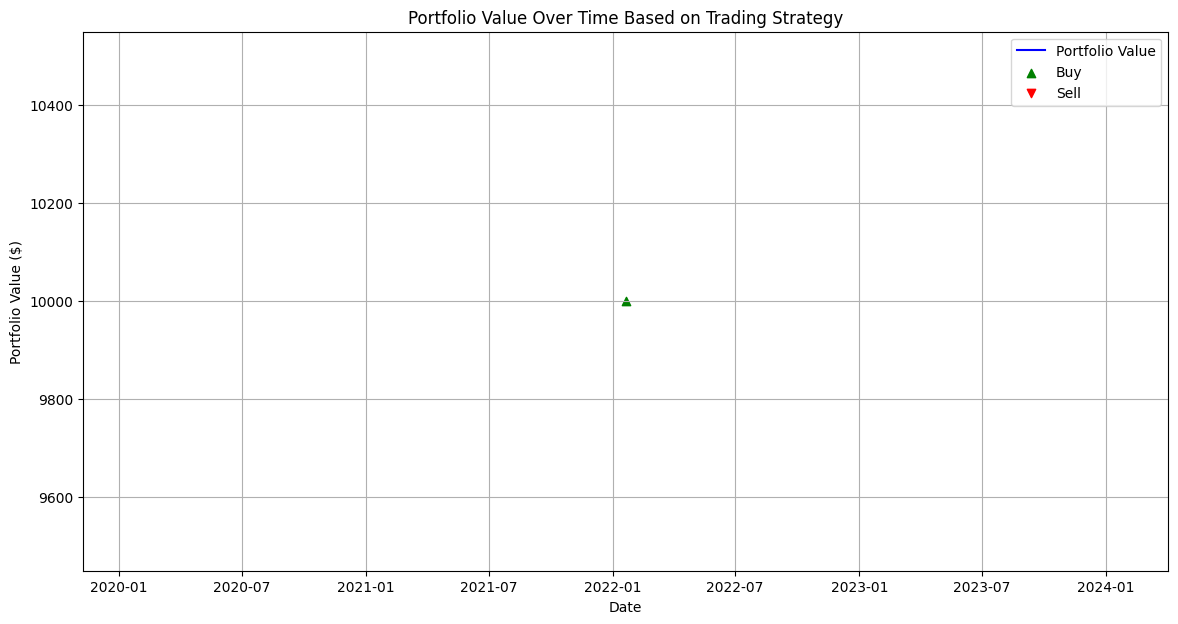

In [ ]:
# Convert trade log to DataFrame
df = pd.DataFrame(trade_log, columns=['Date', 'Action', 'Price'])

# Ensure the dates are in chronological order
df = df.sort_values(by='Date').reset_index(drop=True)

# Initialize balance and holdings
initial_balance = 10000
balance = initial_balance
holdings = 0
portfolio_values = []

# Simulate the portfolio value over time
for index, row in df.iterrows():
    if row['Action'] == 'BUY' and balance > 0:
        holdings = balance / row['Price']
        balance = 0
    elif row['Action'] == 'SELL' and holdings > 0:
        balance = holdings * row['Price']
        holdings = 0

    # Calculate current portfolio value
    portfolio_value = balance + (holdings * row['Price'])
    portfolio_values.append(portfolio_value)

# Convert portfolio values to DataFrame for plotting
portfolio_df = pd.DataFrame({'Date': df['Date'], 'Portfolio Value': portfolio_values})

# Plot the portfolio value over time
plt.figure(figsize=(14, 7))
plt.plot(portfolio_df['Date'], portfolio_df['Portfolio Value'], label='Portfolio Value', color='blue')
plt.scatter(df[df['Action'] == 'BUY']['Date'], portfolio_df.loc[df['Action'] == 'BUY', 'Portfolio Value'], color='green', label='Buy', marker='^')
plt.scatter(df[df['Action'] == 'SELL']['Date'], portfolio_df.loc[df['Action'] == 'SELL', 'Portfolio Value'], color='red', label='Sell', marker='v')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Value Over Time Based on Trading Strategy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import torch
import torch.nn as nn

class Custom1DModel(nn.Module):
    def __init__(self, input_length):
        super(Custom1DModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=39, kernel_size=6)
        self.conv2 = nn.Conv1d(in_channels=39, out_channels=25, kernel_size=4)
        # Calculate the length after convolutions
        conv_output_length = input_length - 6 + 1 - 4 + 1
        self.fc1 = nn.Linear(conv_output_length * 25, 88)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        return x

# Define the input length (50 as per the found match)
input_length = 50

# Initialize the model
model = Custom1DModel(input_length)

# Calculate total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters:", total_params)


Total number of parameters: 96686


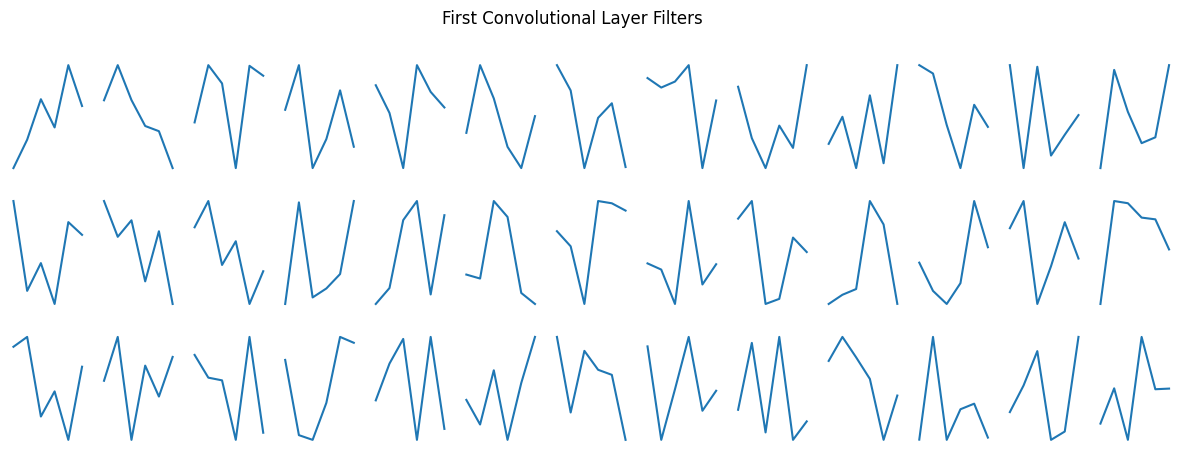

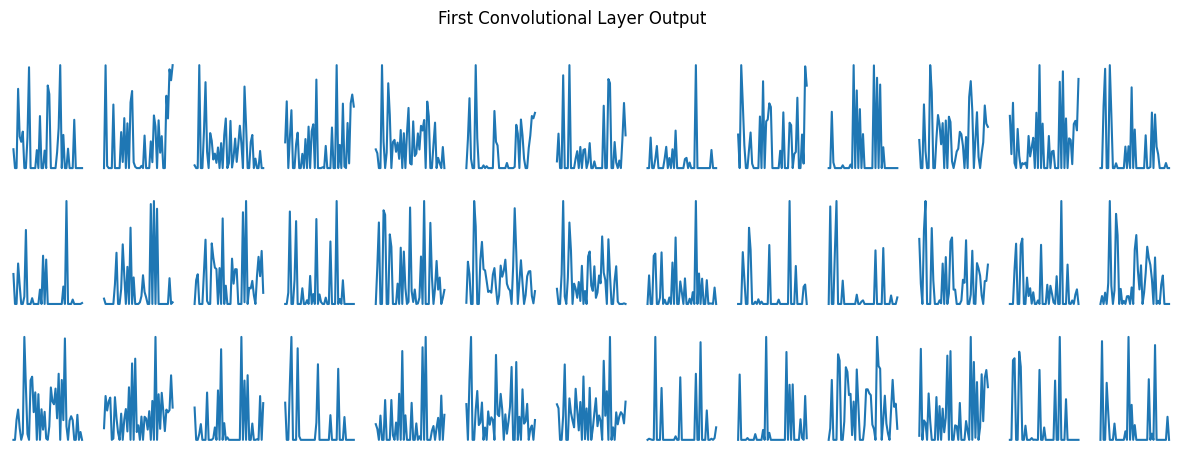

In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Function to visualize the weights of the first convolutional layer
def visualize_conv1_weights(model):
    weights = model.conv1.weight.data.numpy()
    fig, axes = plt.subplots(3, 13, figsize=(15, 5))
    for i, ax in enumerate(axes.flat):
        if i < weights.shape[0]:
            ax.plot(weights[i, 0, :])
        ax.axis('off')
    plt.suptitle('First Convolutional Layer Filters')
    plt.show()

# Function to visualize the output of the first convolutional layer
def visualize_conv1_output(model, input_sequence):
    model.eval()
    with torch.no_grad():
        conv1_output = model.conv1(input_sequence)
        conv1_output = F.relu(conv1_output).numpy()
    fig, axes = plt.subplots(3, 13, figsize=(15, 5))
    for i, ax in enumerate(axes.flat):
        if i < conv1_output.shape[1]:
            ax.plot(conv1_output[0, i, :])
        ax.axis('off')
    plt.suptitle('First Convolutional Layer Output')
    plt.show()

# Generate a random input sequence
input_sequence = torch.randn(1, 1, 50)

# Visualize the filters and output
visualize_conv1_weights(model)
visualize_conv1_output(model, input_sequence)


[*********************100%%**********************]  1 of 1 completed


Number of rows after dropping NaN values: 202
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-10-02  171.220001  174.300003  170.929993  173.750000  173.065521   
2023-10-03  172.259995  173.630005  170.820007  172.399994  171.720840   
2023-10-04  171.089996  174.210007  170.970001  173.660004  172.975891   
2023-10-05  173.789993  175.449997  172.679993  174.910004  174.220963   
2023-10-06  173.800003  177.990005  173.179993  177.490005  176.790802   

              Volume  Sentiment       MA_10       MA_50        RSI  \
Date                                                                 
2023-10-02  52164500          0  173.740001  180.902000  43.719548   
2023-10-03  49594600          0  173.073000  180.495000  41.454016   
2023-10-04  53020300          0  172.889999  180.095800  44.352450   
2023-10-05  48527900          0  172.988000  179.704001  47.147886   
2023-10-06  572

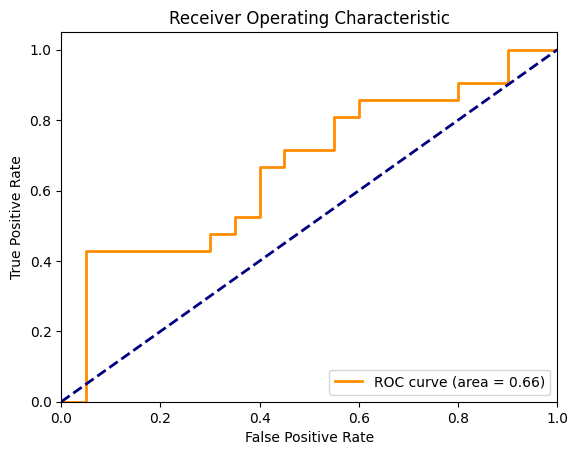

        Date       Close  Probability Decision
0 2024-07-19  224.309998     0.410083     Sell


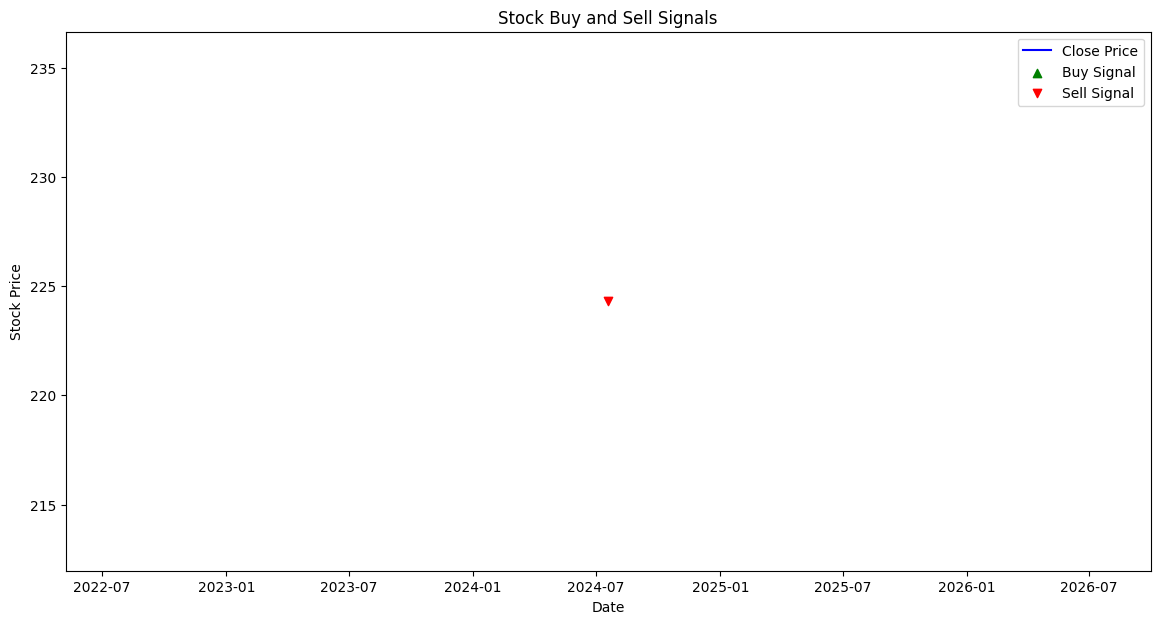

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import requests
from bs4 import BeautifulSoup
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import warnings
import logging
from imblearn.over_sampling import SMOTE
import ta
from datetime import datetime, timedelta

# Suppress warnings
warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(level=logging.WARNING)

# Set up sentiment analysis pipeline with specified model and tokenizer
model_name = 'distilbert-base-uncased-finetuned-sst-2-english'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_analyzer = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

# Function to scrape Bloomberg News and perform sentiment analysis
def scrape_bloomberg_news():
    url = 'https://www.bloomberg.com'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    articles = []
    for item in soup.find_all('article'):
        headline = item.find('h3')
        if headline:
            headline_text = headline.get_text(strip=True)
            link = headline.find('a')['href']
            if link.startswith('/'):
                link = url + link
            articles.append((headline_text, link))

    return articles

# Function to perform sentiment analysis on headlines
def analyze_sentiments(headlines):
    sentiments = []
    for headline in headlines:
        sentiment = sentiment_analyzer(headline)
        sentiments.append(sentiment[0]['score'] if sentiment[0]['label'] == 'POSITIVE' else -sentiment[0]['score'])
    return np.mean(sentiments)  # Return the average sentiment score

# Function to get sentiment score from scraped news
def analyze_headlines():
    headlines = scrape_bloomberg_news()
    headline_texts = [headline[0] for headline in headlines]
    if len(headline_texts) > 0:
        return analyze_sentiments(headline_texts)
    else:
        return 0  # Default to neutral sentiment if no headlines are found

# Function to fetch historical stock price data
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Function to backtest the strategy and calculate probabilities
def backtest_strategy(data, model, start_index, end_index):
    predictions = []
    for i in range(start_index, end_index):
        features = data[['Close', 'MA_10', 'MA_50', 'Sentiment', 'RSI', 'BB_upper', 'BB_lower']].iloc[i].values.reshape(1, -1)
        prob = model.predict_proba(features)[:, 1][0]
        predictions.append(prob)
    return predictions

# Calculate date range dynamically
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

# Fetch the most recent data for Apple (AAPL)
ticker = 'AAPL'
stock_data = fetch_stock_data(ticker, start_date, end_date)

# Get sentiment score
average_sentiment = analyze_headlines()

# Add sentiment score as a feature to the stock data
stock_data['Sentiment'] = average_sentiment

# Add more features like moving averages and technical indicators
stock_data['MA_10'] = stock_data['Close'].rolling(window=10).mean()
stock_data['MA_50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['RSI'] = ta.momentum.rsi(stock_data['Close'], window=14)
stock_data['BB_upper'], stock_data['BB_middle'], stock_data['BB_lower'] = ta.volatility.bollinger_hband(stock_data['Close']), ta.volatility.bollinger_mavg(stock_data['Close']), ta.volatility.bollinger_lband(stock_data['Close'])

# Create target variable
stock_data['Target'] = (stock_data['Close'].shift(-1) > stock_data['Close']).astype(int)

# Drop rows with NaN values
stock_data = stock_data.dropna()

# Debug: Check the number of rows after dropping NaN values
print(f'Number of rows after dropping NaN values: {len(stock_data)}')
print(stock_data.head())

# Prepare the dataset
features = stock_data[['Close', 'MA_10', 'MA_50', 'Sentiment', 'RSI', 'BB_upper', 'BB_lower']]
target = stock_data['Target']

X = features
y = target

# Ensure lengths match
assert len(X) == len(y), f"Inconsistent lengths: len(X)={len(X)}, len(y)={len(y)}"

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform SMOTE to balance the dataset
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a base model
rf = RandomForestClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_res, y_res)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

# Train the model with the best parameters
model = RandomForestClassifier(**best_params, random_state=42)
model.fit(X_res, y_res)

# Predict probabilities
y_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
print(f'Model Accuracy: {accuracy}')
print(f'ROC AUC Score: {roc_auc}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Example backtesting
start_index = 200  # Example starting point for backtesting
end_index = len(stock_data) - 1
predictions = backtest_strategy(stock_data, model, start_index, end_index)

# Calculate the probabilities of stock movements
probabilities = pd.DataFrame(predictions, columns=['Probability'])
probabilities['Date'] = stock_data.index[start_index:end_index]
probabilities['Close'] = stock_data['Close'][start_index:end_index].values

# Example decision making based on probabilities
def make_decision(probability, threshold=0.6):
    if probability > threshold:
        return 'Buy'
    else:
        return 'Sell'

# Applying the decision-making logic
probabilities['Decision'] = probabilities['Probability'].apply(make_decision)

# Display the decisions
print(probabilities[['Date', 'Close', 'Probability', 'Decision']])

# Visualize the decisions
plt.figure(figsize=(14, 7))
plt.plot(probabilities['Date'], probabilities['Close'], label='Close Price', color='blue')
buy_signals = probabilities[probabilities['Decision'] == 'Buy']
sell_signals = probabilities[probabilities['Decision'] == 'Sell']
plt.scatter(buy_signals['Date'], buy_signals['Close'], label='Buy Signal', marker='^', color='green')
plt.scatter(sell_signals['Date'], sell_signals['Close'], label='Sell Signal', marker='v', color='red')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Buy and Sell Signals')
plt.legend()
plt.show()
